# Исследование неслучайности выпадающих множителей

In [1]:
# набор стандартных библиотек для python
import pandas as pd
import numpy as np
#import numba
#from scipy.stats import norm
#import matplotlib.pyplot as plt
#from numba import njit, jit
#from numpy.random import exponential

In [2]:
df=pd.read_csv('crash_agg_20230313.tsv', sep='\t',header=0, decimal=',',
                #names=['timestamp','point'],parse_dates= [0],
               dayfirst=True)
print(df.dtypes)
print(df.shape)
df.head(3)

PlayID                int64
Полёт (getx)        float64
Дата и время         object
Начало              float64
Окончание           float64
Полёт (мс)            int64
Пропорция           float64
Игроков (всего)       int64
Призфонд (всего)      int64
Игроков (топ)         int64
Призфонд (топ)      float64
Призфонд (%)        float64
Игроки+ (чел)         int64
Игроки+ (%)         float64
Среднее (ratio)     float64
ОргиТоп (руб)       float64
ИгрокиТоп (руб)     float64
ОргиВсё (руб)       float64
ИгрокиВсе (руб)     float64
Орги (баланс)       float64
dtype: object
(58, 20)


,PlayID,Полёт (getx),Дата и время,Начало,Окончание,Полёт (мс),Пропорция,Игроков (всего),Призфонд (всего),Игроков (топ),Призфонд (топ),Призфонд (%),Игроки+ (чел),Игроки+ (%),Среднее (ratio),ОргиТоп (руб),ИгрокиТоп (руб),ОргиВсё (руб),ИгрокиВсе (руб),Орги (баланс)
0,1678725275,1.05,13.03.2023 16:34:35,44998.690688,44998.690695,653,621.905,268,28428,30,20561.0,72.3,1,3.33,1.04,20316.0,254.8,27921.0,527.2,27900.8
1,1678725284,2.87,13.03.2023 16:34:44,44998.690790,44998.690895,9104,3172.125,222,17397,30,11686.2,67.2,28,93.33,1.53,476.0,17944.4,856.9,26099.1,-8702.1
2,1678725301,5.66,13.03.2023 16:35:01,44998.690986,44998.691155,14565,2573.322,263,17154,30,11221.5,65.4,30,100.00,1.74,0.0,19425.3,0.0,29747.9,-12593.9


In [3]:
df=df[['PlayID','Полёт (getx)','Дата и время', 'Орги (баланс)']]
df=df.rename(columns={"PlayID": "playid", "Полёт (getx)": "multiplier",'Дата и время':'timestamp','Орги (баланс)':'orgbalance'})

In [4]:
df.head(3)

,playid,multiplier,timestamp,orgbalance
0,1678725275,1.05,13.03.2023 16:34:35,27900.8
1,1678725284,2.87,13.03.2023 16:34:44,-8702.1
2,1678725301,5.66,13.03.2023 16:35:01,-12593.9


In [5]:
# данные ставок пользователей пока загружать не будем

#users=pd.read_csv('crash_users_bets_20230313.tsv', sep='\t',header=0, decimal=','
#                #names=['timestamp','point'],parse_dates= [0],
#               )
#print(users.dtypes)
#print(users.shape)
#users.head(3)

Накопительный баланс оргов в виде скользящей  суммы

<AxesSubplot: >

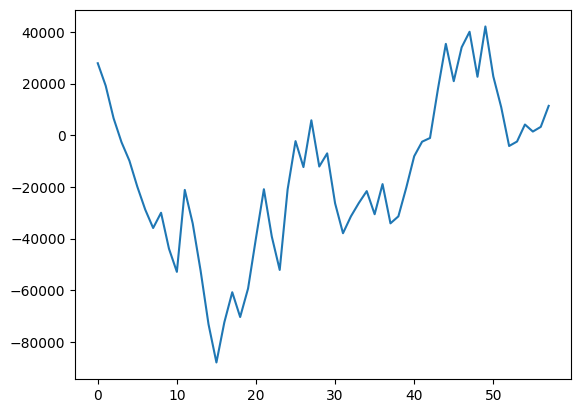

In [6]:
df.orgbalance.cumsum().plot()

In [7]:
# скользящая сумма (куммулятивная)
df['orgcumsum']=df.orgbalance.cumsum()
# логарифм от мультипликатора
df['logmultiplier']=np.log(df.multiplier)
df.head(3)

/home/pavlo/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,playid,multiplier,timestamp,orgbalance,orgcumsum,logmultiplier
0,1678725275,1.05,13.03.2023 16:34:35,27900.8,27900.8,0.048790
1,1678725284,2.87,13.03.2023 16:34:44,-8702.1,19198.7,1.054312
2,1678725301,5.66,13.03.2023 16:35:01,-12593.9,6604.8,1.733424


In [8]:
# баланс на предыдущем шаге
df['prevorgbalance']=df.shift(1).orgbalance

In [9]:
# Результат
df.head(3)

,playid,multiplier,timestamp,orgbalance,orgcumsum,logmultiplier,prevorgbalance
0,1678725275,1.05,13.03.2023 16:34:35,27900.8,27900.8,0.048790,NaN
1,1678725284,2.87,13.03.2023 16:34:44,-8702.1,19198.7,1.054312,27900.8
2,1678725301,5.66,13.03.2023 16:35:01,-12593.9,6604.8,1.733424,-8702.1


In [10]:
# отберем только нужные колонки
logdf=df[['prevorgbalance','logmultiplier']]
logdf.head(3)

,prevorgbalance,logmultiplier
0,NaN,0.048790
1,27900.8,1.054312
2,-8702.1,1.733424


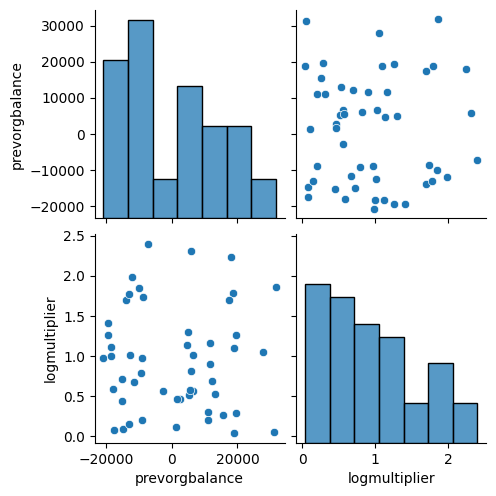

In [11]:
# специальный вид парных графиков для оценки корреляций
import seaborn as sns
sns.pairplot(logdf);

Классический способ вычисления корреляций в виде числа

In [12]:
logdf.corr()

,prevorgbalance,logmultiplier
prevorgbalance,1.000000,-0.020125
logmultiplier,-0.020125,1.000000


In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [14]:
mod = smf.ols(formula='logmultiplier ~ prevorgbalance', data=logdf)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          logmultiplier   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 13 Mar 2023   Prob (F-statistic):                nan
Time:                        19:10:14   Log-Likelihood:                    nan
No. Observations:                  57   AIC:                               nan
Df Residuals:                      55   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept            -inf        nan        

/home/pavlo/.local/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1703: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


Ничего не сошлось. Алгоритм не видит никакой связи между двумя переменными.

# Вывод - непонятно.
Есть весьма умеренно выраженная отрицательная корреляция между балансом организатора и логарифмом выпадающего множителя, но данных недостаточно чтобы уверенно заключить это.